### konlpy 라이브러리 설치

In [1]:
!pip install konlpy

     |████████████████████████████████| 19.4MB 10.7MB/s 
     |████████████████████████████████| 2.3MB 38.3MB/s 
     |████████████████████████████████| 92kB 11.1MB/s 
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


### Matplotlib 한글 폰트 설정
* 아래 셀 실행 시 바로 한글 폰트 적용됨

In [21]:
# 그래프에서 한글표현을 위해 폰트를 설치합니다.
%config InlineBackend.figure_format = 'retina'

!apt -qq -y install fonts-nanum > /dev/null

import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)

# 기본 글꼴 변경
import matplotlib as mpl
mpl.font_manager._rebuild()
mpl.pyplot.rc('font', family='NanumBarunGothic')

### OPEN API 데이터 수집 및 전처리, 시각화를 위한 라이브러리 임포트 

In [0]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

from gensim.models.fasttext import FastText
from konlpy.tag import Okt
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.decomposition import PCA

### OPEN API 데이터 수집을 위한 토큰 및 url 포멧터 정의
* url 포멧터 : document(https://data.seoul.go.kr/dataList/datasetView.do?infId=OA-1128&srvType=A&serviceKind=1&currentPageNo=1&searchValue=&searchKey=null)


> - tocken : 서울데이터광장 OPEN API에 데이터 요청을 위해 발급받은 토큰 정보
- service : OPEN API의 종류(SearchFAQService : 서울시 다산콜센터 자주묻는질문 목록 조회/ SearchDetailsFAQService : 서울시 다산콜센터 자주묻는질문 FAQ 상세 조회 ★★★★★)
- start_index : SearchFAQService 서비스 이용시 사용되는 값, 조회되는 데이터의 시작 index
- end_index : SearchFAQService 서비스 이용시 사용되는 값, 조회되는 데이터의 끝 index, start_index 와 end_index 간의 차이는 1000을 넘을 수 없다
- faq_type :  서울시 다산콜센터 자주문는질문 목록의 게시판 유형



In [0]:
tocken = '5a43694a6d696d6a33397450765558'
start_index = 1
term_index = 1000
url_format = "http://openAPI.seoul.go.kr:8088/{tocken}/xml/{service}/{start_index}/{end_index}/{faq_type}/"

### Q1. getFaqContents 함수를 구현 하시오
* 전달받은 row에서 faq_tp, faq_seq_no 정보 추출
* url_format 이용하여 하나의 faq_seq_no 값을 가진 문서를 조회하기 위한 url 생성


> * 게시판의 상세 정보를 조회 하기 위해 service='SearchDetailsFAQService' 세팅
* faq_seq_no를 가지고 하나의 문서만 조회 하기 때문에 start_index, end_index 모두 1로 세팅
* QUEST 태그 객체화 ANSWER 태그 객체 조회 하여 입력 받은 row 변수에 faq_quest: QUEST 값,faq_answer: ANSWER 값 추가 하여 return
* 게시판의 목록 정보를 조회 하기 위해 service='SearchDetailsFAQService' 세팅




In [0]:
def getFaqContents(row):

  # 전달받은 row에서 faq_tp, faq_seq_no 정보 추출
  faq_tp = row['faq_tp'].string
  faq_seq_no = row['faq_seq_no'].string
  
  # url_format 이용하여 하나의 faq_seq_no 값을 가진 문서를
  # 조회하기 위한 url 생성
  faq_url = url_format.format(tocken=tocken,
                              service='SearchDetailsFAQService',
                              start_index=1, end_index=1,
                              faq_type=faq_tp)\
            + faq_seq_no

  # url 정보를 이용하여 받은 정보(xml))를 soup 객체로 파싱    
  response= requests.get(faq_url)
  soup = BeautifulSoup(response.content, 'xml')
  
  # soup 객체에서 QUEST 태그 객체와 ANSWER 태그 객체에서 텍스트 정보 추출
  faq_quest  = soup.find_all('QUEST')[0].string
  faq_answer = soup.find_all('ANSWER')[0].string
    
  # 입력받은 row 값에 추출한 QUEST 정보와 ANSWER 정보를 추가 할당 후 반환
  row['faq_quest'] = faq_quest
  row['faq_answer'] = faq_answer
    
  return row

### Q2. 서울시 다산콜센터 자주묻는질문 목록에서 9000개의 문서 조회해서 질문(QUEST) 과 대답(ANSWER) 정보 조회 하여 df_faq 객체에 할당
* 게시판의 상세 정보를 조회 하기 위해 service='SearchFAQService' 세팅
* 전체 게시판에 대해서 데이터 조회 하기위해 faq_type='' 세팅
* 9000건 모두 조회시 시간이 오래 걸리므로 1000건만 조회

In [6]:
df_faq = pd.DataFrame()

# 9*1000 개의 문서를 조회 하기 위한 loop
for roop_index in range(1):
  # 각 loop 횟수에 맞기 start_index, end_index 값 변경
  start_index = roop_index * term_index + 1
  end_index = (roop_index + 1) * term_index

  # 게시판목록 정보 조회를 위한 url 생성
  url = url_format.format(tocken=tocken,
                          service='SearchFAQService',
                          start_index=start_index, end_index=end_index,
                          faq_type='')

  # url로 조회 하여 얻은 데이터(xml) 을 soup 객체로 파싱
  response= requests.get(url)
  soup = BeautifulSoup(response.content, 'lxml')

  # 문서의 고유한 번호인 'faq_seqno', 게시판의 유형 정보인 'faq_top' 객체 조회
  faq_seq_nos = soup.find_all('faq_seqno')
  faq_tps = soup.find_all('faq_tp')

  # 'faq_seqno', 'faq_top' 객체 조회 값을 이용해 dataframe 객체 생성
  faq_data = {
      'faq_seq_no': faq_seq_nos,
      'faq_tp' : faq_tps
  }

  df_faq_tmp = pd.DataFrame(faq_data)
  # Q1. 에서 정의한 함수를 dataframe 객체의 apply(axis='columns')) 함수를 이용하여 dataframe 객체에 적용
  df_faq_tmp = df_faq_tmp.apply(getFaqContents, axis='columns')
  # row에 하나의 Nan 값만 가져도 Drop
  df_faq_tmp = df_faq_tmp.dropna(how='any')

  # 수집된 데이터를 모으는 df_fq 객체에 매 스텝 마다 조회할 결과 추가
  df_faq = df_faq.append(df_faq_tmp, ignore_index=True)
  
  print('end index {}'.format(end_index))
  break

end index 1000


### Q3. 전달받은 rows에서 개행문자(\n, \r)를 제거 하는 remove_line_breaks 함수 구현 및 적용
* df_faq 객체의 .apply() 함수이용해 'faq_answer' 컬럼값에 존재하는 개행문자 제거

In [0]:
def remove_line_breaks(row):
  row = row.replace('\n', '').replace('\r', '')
  return row

In [0]:
df_faq['faq_answer'] = df_faq['faq_answer'].apply(remove_line_breaks)

### Q4. konlpy 라이브러리의 okt 형태소 분석기 이용하여 df_faq 객체의 'faq_quest', 'faq_answer' 컬럼 정보들의 토큰을 생성
* 토큰 생성 결과를 각 각 df_faq 객체 'faq_quest_parsed', 'faq_answer_parsed' 컬럼을 추가 하여 할당
* df_faq 객체의 apply() 함수 사용


In [0]:
okt = Okt()

In [0]:
df_faq['faq_quest_parsed'] = df_faq['faq_quest'].apply(okt.morphs)
df_faq['faq_answer_parsed'] = df_faq['faq_answer'].apply(okt.morphs)

### Q5. gensim 패키지의 FastText api 를 이용하여 단어 임베딩 모델 생성
* size=25(임베딩 차원)
* window=3(window size)
* min_count=1(발생 빈도 수가 작은 단어 학습에서 제외)
* epochs=10(학습 횟수)
* 학습 완료 후 특정 단어를 이용해 유사한 단어 10개 출력

In [11]:
ft_model = FastText(size=25, window=3, min_count=1)
ft_model.build_vocab(sentences=df_faq['faq_answer_parsed'])
ft_model.train(sentences=df_faq['faq_answer_parsed'], total_examples=len(df_faq['faq_answer_parsed']), epochs=10)

print(ft_model)

FastText(vocab=8363, size=25, alpha=0.025)


In [12]:
ft_model.most_similar('사항')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('권기타사항', 0.9520386457443237),
 ('기타사항', 0.9470522999763489),
 ('문의', 0.93488609790802),
 ('문의사항', 0.9277389645576477),
 ('문의서', 0.9208703637123108),
 ('유의사항', 0.9038227200508118),
 ('보컬', 0.8984168767929077),
 ('전문의', 0.8935851454734802),
 ('부정', 0.8849148154258728),
 ('자세한', 0.8726990818977356)]

### Q6. 학습된 단어 임베딩 모델(model)에 임베딩 값을 PCA 차원 감소를 통해 2차원 으로 변경 후 산포도로 시각화 함수 정의
* 함수를 이용해 샘플 단어 15개 랜덤으로 생성 하게 한 후 해당 정보로 산포도 조회

In [0]:
def display_pca_scatterplot(model, words=None, sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.wv.vocab.keys()), sample)
        else:
            words = [ word for word in model.wv.vocab ]

    # words 리스트에 담겨 있는 단어를 model에 전달하여 해당 단어의 벡터 값 조회    
    word_vectors = np.array([model[w] for w in words])

    # word_vectors 에 담겨 있는 단어 벡터를 PCA 알고리즘을 이용해 중요도 순으로 축 정보를 변경 후
    # 상위 2개의 축에 해당하는 정보만 가져와서 2차원으로 차원축소
    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    # 6X6 사이즈로 차트의 크기 설정
    plt.figure(figsize=(6,6))

    # 2차원으로 차원 축소된 단어 벡터를 산점도 차트로 시각화
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')

    # 산점도에 그려진 각 각의 점마다 해당 점의 단어 텍스트 정보 추가
    # 텍스트 추가 position = x+0.0005, y+0.0005
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.0005, y+0.0005, word)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 50696 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:176: RuntimeWarning: Glyph 50696 missing from current font.
  font.load_char(ord(s), flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 51076 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyp

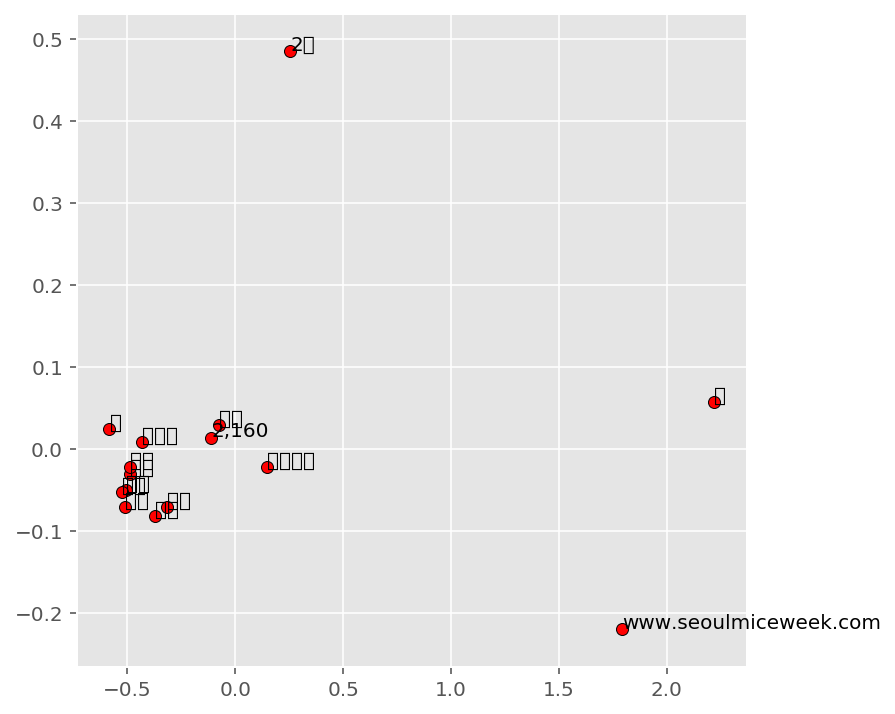

In [22]:
display_pca_scatterplot(ft_model, sample=15)

### Counter 객체를 이용하여 df_faq['faq_answer_parsed'] 컬럼내에 있는 형태소들의 발생 빈도 계산 

In [0]:
from collections import Counter

In [16]:
faq_answer_parsed_lst = [y for x in df_faq['faq_answer_parsed'].to_list() for y in x]

counter = Counter(faq_answer_parsed_lst)
counter.most_common(20)

[(',', 2094),
 ('(', 1842),
 (')', 1721),
 (':', 1417),
 ('○', 1377),
 ('-', 1044),
 ('\u3000', 838),
 ('~', 706),
 ('을', 635),
 ('의', 624),
 ('▣', 580),
 ('에', 543),
 ('및', 512),
 ('서울', 438),
 ('.', 433),
 ('내용', 413),
 ('를', 407),
 ('※', 405),
 ('1', 384),
 ('등', 379)]

### 발생 빈도 확인 결과 상위에 분석에 방해가 되는 특수문자 존재

### Q7. 아래 Stop word 를 적용하여 df_faq['faq_answer_parsed'] 컬럼 안에 있는 데이터 전처리
* '○', '(', ')', '\u3000', '[', ']', '▣', '※'
* remove_stopwords 함수 정의 후 df_faq 객체의 apply 함수 이용하여 stop word 제거

In [0]:
STOP_WORDS = ('○', '(', ')', '\u3000', '[', ']', '▣', '※')

In [0]:
def remove_stopwords(tokens):
  return [t for t in tokens if t not in STOP_WORDS]

In [0]:
df_faq['faq_answer_parsed'] = df_faq['faq_answer_parsed'].apply(remove_stopwords)

### counter.most_common(30) 데이터를 이용해 dataframe 객체 생성 후 bar 차트를 이용해 데이터 시각화

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12288 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 51012 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 50640 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 48143 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 49436 missing from current font.
  font.set_

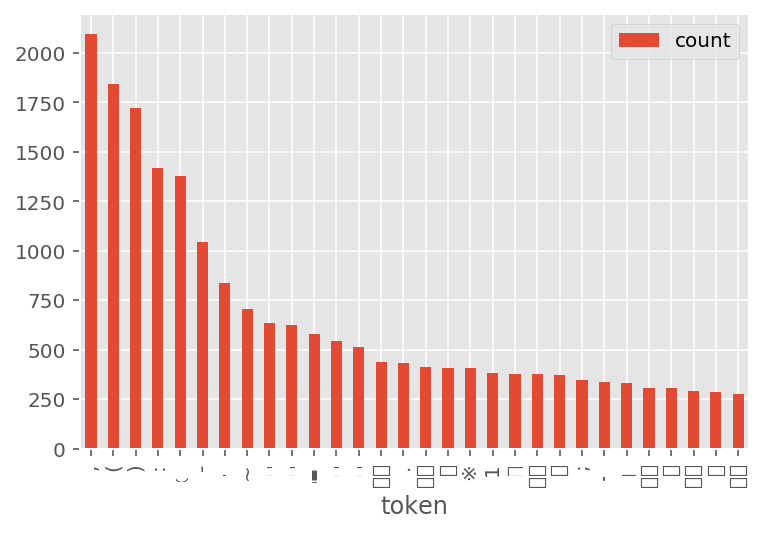

In [20]:
df_frequence = pd.DataFrame(counter.most_common(30),
                            columns=['token', 'count'])
df_frequence.plot(kind='bar', x='token')

### wordcloud 를 이용한 시각화

* wordcloud 라이브러리 임포트

In [0]:
from wordcloud import WordCloud

* wordcloud 시각화 시 사용할 한글 폰트 경로 지정

In [0]:
font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

* wordcloud 시각화를 위한 함수 정의

In [0]:
def wordColud(counter):
  # wordcloud 객체 생성
  wc = WordCloud(width=1200,
                 height=800,
                 background_color='white',
                 max_words=200,
                 font_path=font_path)
  # wordcloud 객체에 데이터 매핑
  wc.generate_from_frequencies(counter)

  # matplot 라이브러리를 이용하여 wordcloud 차트 생성 
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis=('off')
  plt.tight_layout(pad=0)
  plt.show()

* wordCloud 함수 호출 하여 차트 시각화

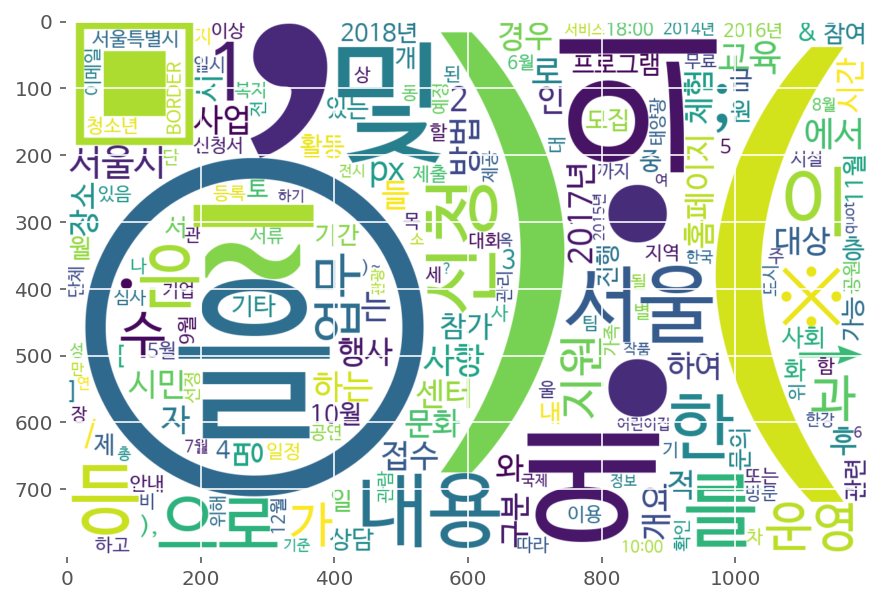

In [26]:
wordColud(counter)

### Q8. df_faq['faq_answer'] 컬럼의 정보를 명사 값만 가져오도록 토큰 생성 후 분석 및 시각화 코드 작성
* okt 형태소 분석기를 이용하여 명사 토큰 추출
* Counter 객체를 이용해 각 토큰별 발생 횟수 카운트 후 발생 빈도 기준 상위 20개 단어 출력
* 생성한 Counter 객체를 이용해 x축 : 토큰/ y축 : 발생 횟수 로 하는 bar 차트 시각화
* 생성한 Counter 객체를 이용하여 word 클라우드 시각화

In [0]:
df_faq['faq_answer_parsed_noun'] = df_faq['faq_answer'].apply(okt.nouns)

In [28]:
faq_answer_parsed_noun_lst = [y for x in df_faq['faq_answer_parsed_noun'].to_list() for y in x]

counter = Counter(faq_answer_parsed_noun_lst)
counter.most_common(20)

[('및', 512),
 ('서울', 438),
 ('내용', 413),
 ('등', 379),
 ('신청', 376),
 ('운영', 291),
 ('업무', 275),
 ('수', 264),
 ('지원', 238),
 ('서울시', 232),
 ('교육', 226),
 ('사항', 207),
 ('방법', 197),
 ('접수', 184),
 ('사업', 183),
 ('센터', 179),
 ('개요', 176),
 ('시민', 173),
 ('홈페이지', 170),
 ('대상', 159)]

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 48143 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 49436 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 50872 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 45236 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 50857 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 46321 missing from current font.
  font.set_

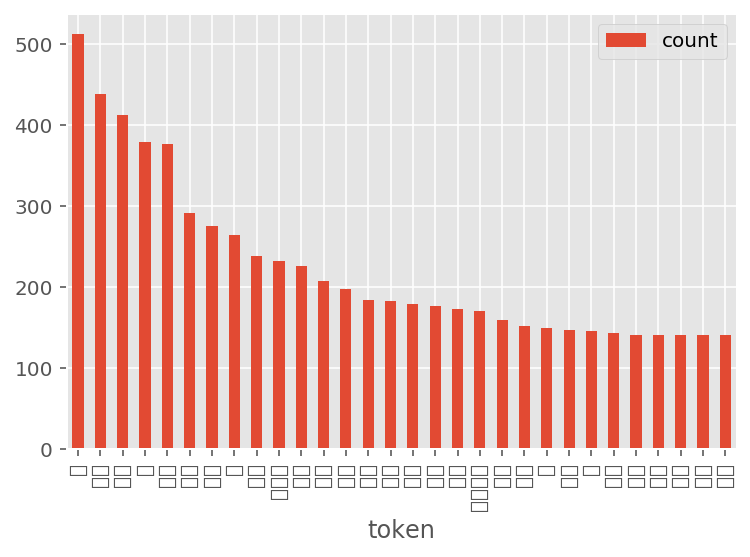

In [29]:
df_frequence = pd.DataFrame(counter.most_common(30),
                            columns=['token', 'count'])
df_frequence.plot(kind='bar', x='token')

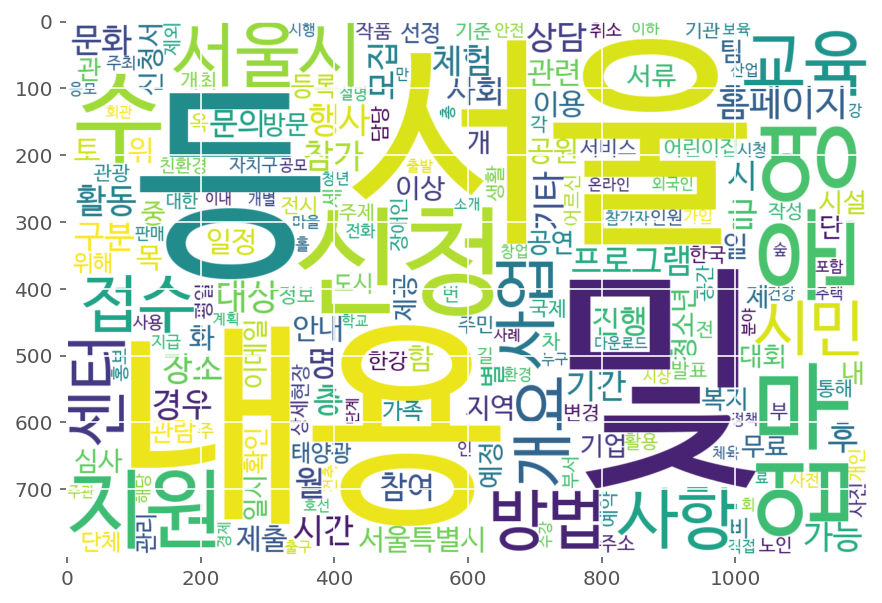

In [30]:
wordColud(counter)